In [390]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from pathlib import Path

from tqdm import trange

In [391]:
plt.rcParams['figure.figsize']=[8,8]

## Read points

In [392]:
def read_points(fl: str):
    "Reads points from text file"
    fl = Path(fl)
    points = []
    with fl.open() as f:
        line = f.readline()
        line = f.readline()            
        while line:
            x,y = line.split()
            points.append((float(x), float(y)))
            line = f.readline()            
    return np.array(points, dtype=np.float32)

In [420]:
points10 = read_points('data/tsp10.txt')
points100 = read_points('data/tsp100.txt')
points1000 = read_points('data/tsp1000.txt')

## Ants optimization

In [394]:
class AntOpt():
    def __init__(self, 
                 points, 
                 d_matrix = None,
                 dist='euclid',
                 n_iter=300, 
                 n_ants=10, 
                 alpha=2,   # pheromone importance
                 beta=3,    # local importance heuristic
                 rho=0.85,  # evaporation
                 Q=0.3,
                 tau0=1e-4  # initial pheromone level
                ):

        self.n_iter = n_iter
        self.n_ants = n_ants
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.Q = Q
        
        self.points = points
        self.n_points = len(self.points)
        self.cities = np.arange(self.n_points)
        
        self.dist = dist

        if d_matrix is None:
            self.d_matrix = self.calc_distance_matrix(self.points)
        else:
            self.d_matrix = d_matrix
            
        assert (self.d_matrix == self.d_matrix.transpose()).all()

        self.pheremons = tau0*np.ones_like(self.d_matrix)
        np.fill_diagonal(self.pheremons, 0)  #  no transition to the same node
        
        # set seed
        np.random.seed(0)    

    @staticmethod
    def haversine_distance(lon1, lat1, lon2, lat2):
        """
        Calculate the great circle distance between two points
        on the earth (specified in decimal degrees)
        Reference:
            https://stackoverflow.com/a/29546836/7657658
        """
        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(
            dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2

        c = 2 * np.arcsin(np.sqrt(a))
        km = 6371 * c
        return km

    @staticmethod
    def euclid_distance(p1, p2):
        return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)
    
    def calc_distance(self, p1, p2, dist='euclid'):
        """
        Calculate distance between two points
        dist: distance metric [euclid or geo]
        """
        if dist == 'euclid':
            return self.euclid_distance(p1, p2)
        elif dist == 'geo':
            return self.haversine_distance(p1[0], p1[1], p2[0], p2[1])
        else:
            raise('Unknown distance metric, use euclid or geo')

    
    def calc_distance_matrix(self, points: np.array):
        "Calculate distance matrix for array of points"
        n_points = len(points)
        d_matrix = np.zeros((len(points), len(points)), dtype=np.float32)
        for i in range(n_points):
            for j in range(i):
                d_matrix[i,j] = self.calc_distance(points[i,:], points[j, :], dist=self.dist)
        return d_matrix + d_matrix.transpose()  # symmetric

    def path_length(self, path):
        tot_length = 0
        for i in range(len(path)-1):
            tot_length += self.d_matrix[path[i],path[i+1]]
        return tot_length

    def _make_transition(self, ant_tour):
        "Make single ant transition"
        crnt = ant_tour[-1]
        options = [i for i in self.cities if i not in ant_tour]  # no repetition
        probs = np.array([self.pheremons[crnt, nxt]**self.alpha*(1/self.d_matrix[crnt,nxt])**self.beta for nxt in options])
        probs = probs/sum(probs)  # normalize
        next_city = np.random.choice(options, p=probs)
        ant_tour.append(next_city)

        
    def run_ants(self):
        
        # Initizlize last improvement itteration
        last_iter = 0
        # Initizlie optimal length
        optimal_length = np.inf        
        # Keep track of path length improvement
        best_path_lengths = []

        for it in trange(self.n_iter):
            paths = []
            path_lengths = []
            # release ants
            for j in range(self.n_ants):

                # Place ant on random city
                ant_path = [np.random.choice(self.cities)]
                
                # Make ant choose next node until it covered all nodes
                self._make_transition(ant_path)
                while len(ant_path) < self.n_points:
                    self._make_transition(ant_path)
                    
                # Return to starting node
                ant_path += [ant_path[0]]
                
                # Calculate path length
                path_length = self.path_length(ant_path)
                paths.append(ant_path)
                path_lengths.append(path_length)
                
                # Check if new optimal
                if path_length < optimal_length:
                    optimal_path = ant_path
                    optimal_length = path_length
                    last_iter = it
                best_path_lengths.append(optimal_length)

            # Break if no improvements for more than 50 itterations
            if (it - last_iter) > 50:
                print(f'breaking at itteration: {it} with best path length: {optimal_length}')
                break

            # Evaporate pheromons
            self.pheremons = self.rho*self.pheremons

            # update pheremons based on path lengths
            for path, length in zip(paths, path_lengths):
                for i in range(self.n_points - 1):
                    self.pheremons[path[i],path[i+1]] += self.Q/length

            # elitist
            for k in range(self.n_points - 1):
                self.pheremons[optimal_path[k],optimal_path[k+1]] += self.Q/optimal_length

        return optimal_path
    
    def plot_cities(self):
        plt.scatter(self.points[:, 0], self.points[:, 1], s=7, color='k')
        plt.axis('square');

    def plot_path(self, path):
        self.plot_cities()
        plt.plot(self.points[path,0], self.points[path,1], color='k', linewidth=0.6)   
        plt.title(f'Path Length: {self.path_length(path):.1f}')
        
    def __repr__(self):
        return f"Optimizing with {self.n_points} cities, n_iter={self.n_iter}, n_ants={self.n_ants}, alpha={self.alpha}, beta={self.beta}, rho={self.rho}, Q={self.Q}"

## 10 Nodes

In [395]:
ants = AntOpt(points10)
ants

Optimizing with 10 cities, n_iter=300, n_ants=10, alpha=2, beta=3, rho=0.85, Q=0.3

 17%|█▋        | 52/300 [00:01<00:05, 44.81it/s]


breaking at itteration: 52 with best path length: 1552.96120262146


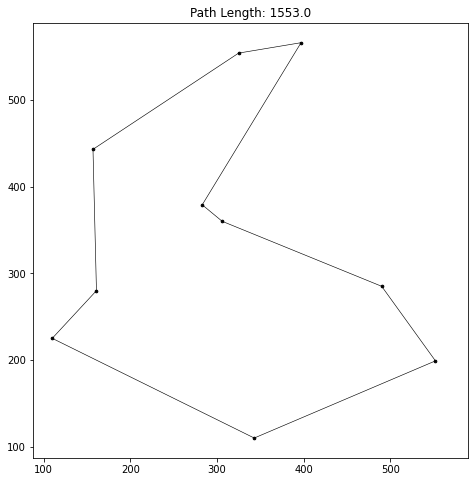

In [396]:
best_path = ants.run_ants()
ants.plot_path(best_path)
plt.savefig('images/10nodes_tsp.png', bbox_inches='tight', transparent=True)

## 100 Nodes

In [400]:
ants = AntOpt(points100, n_ants=15)
ants

Optimizing with 100 cities, n_iter=300, n_ants=15, alpha=2, beta=3, rho=0.85, Q=0.3

 27%|██▋       | 81/300 [01:26<03:53,  1.07s/it]

breaking at itteration: 81 with best path length: 4547.416619062424


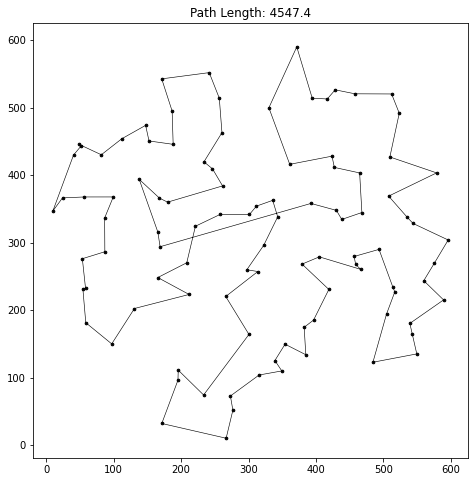

In [401]:
best_path = ants.run_ants()
ants.plot_path(best_path)
plt.savefig('images/100nodes_tsp.png', bbox_inches='tight', transparent=True)

## Capitals path

In [402]:
import geopandas as gpd
import contextily as ctx

In [403]:
capitals = pd.read_csv('data/capitals.csv', usecols=['CountryName','CapitalName', 'CapitalLatitude', 'CapitalLongitude', 'ContinentName'])  # from https://www.kaggle.com/nikitagrec/world-capitals-gps 

In [404]:
# filter to specific countries
countries = ['United Kingdom', 'France', 'Italy','Spain','Germany','Sweden','Norway','Denmark','Iceland','Greece','Switzerland','Austria','Poland','Russia','Israel','United States','Australia','Japan','Brazil','China','Thailand']

In [405]:
capitals = capitals[capitals['CountryName'].isin(countries)].copy()

In [406]:
capitals.dropna(subset=['CapitalName'], inplace=True)

In [407]:
capitals

,CountryName,CapitalName,CapitalLatitude,CapitalLongitude,ContinentName
3,Israel,Jerusalem,31.766667,35.233333,Asia
20,Australia,Canberra,-35.266667,149.133333,Australia
21,Austria,Vienna,48.200000,16.366667,Europe
36,Brazil,Brasilia,-15.783333,-47.916667,South America
51,China,Beijing,39.916667,116.383333,Asia
66,Denmark,Copenhagen,55.666667,12.583333,Europe
81,France,Paris,48.866667,2.333333,Europe
86,Germany,Berlin,52.516667,13.400000,Europe
89,Greece,Athens,37.983333,23.733333,Europe
102,Iceland,Reykjavik,64.150000,-21.950000,Europe


In [408]:
capitals['CapitalLatitude'] = capitals['CapitalLatitude'].astype(np.float32)
capitals['CapitalLongitude'] = capitals['CapitalLongitude'].astype(np.float32)

In [409]:
capitals_points = capitals[['CapitalLongitude','CapitalLatitude']].values

In [410]:
gdf_capitals = gpd.GeoDataFrame(capitals, geometry=gpd.points_from_xy(capitals.CapitalLongitude, capitals.CapitalLatitude))
gdf_capitals.crs = 'epsg:4326'

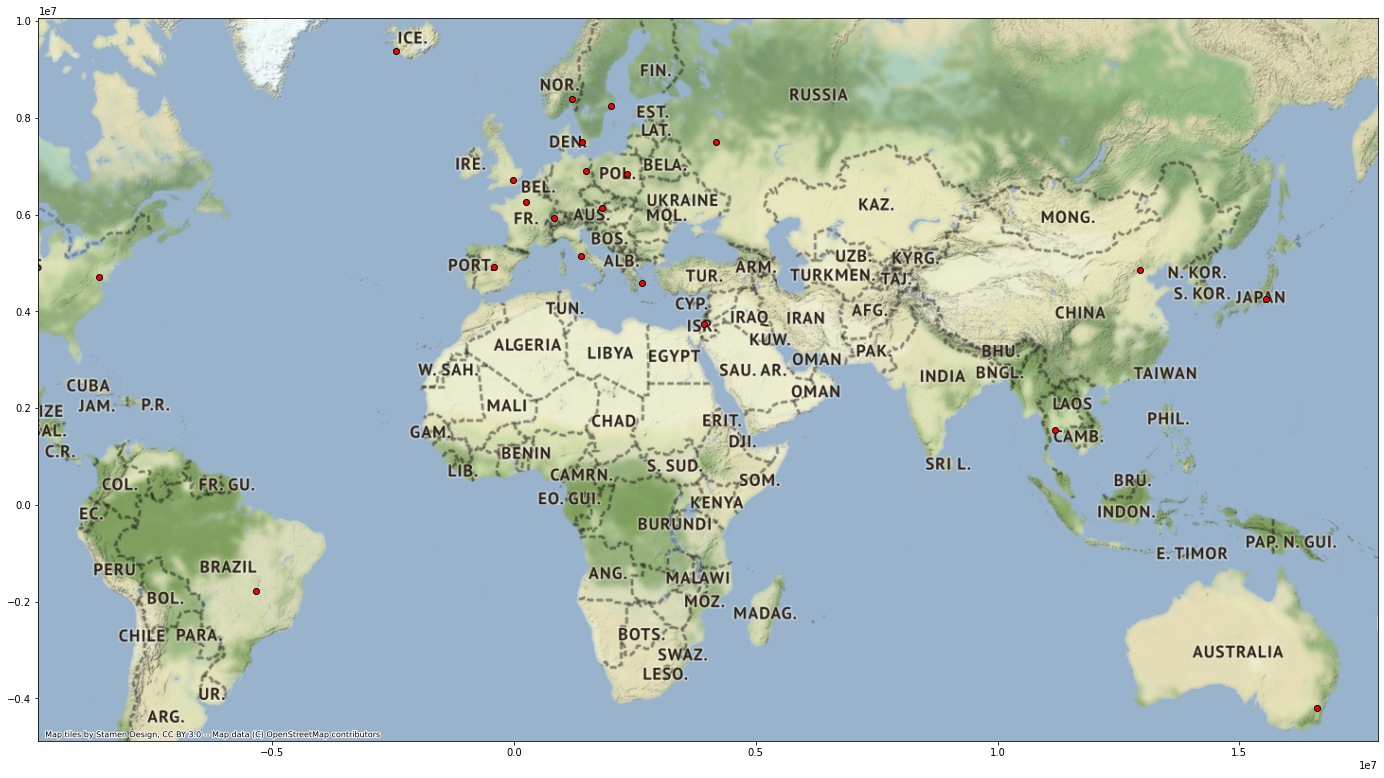

In [411]:
fig, ax = plt.subplots(figsize=(24,24))
gdf_capitals.to_crs('epsg:3857').plot(ax=ax, color='r', edgecolor='k')
ctx.add_basemap(ax)

In [414]:
ants = AntOpt(capitals_points, dist='geo', n_iter=200, n_ants=15, rho=0.85)
ants

Optimizing with 21 cities, n_iter=200, n_ants=15, alpha=2, beta=3, rho=0.85, Q=0.3

 50%|████▉     | 99/200 [00:06<00:06, 15.49it/s]

breaking at itteration: 99 with best path length: 58323.089447021484


(-50.0, 100.0)

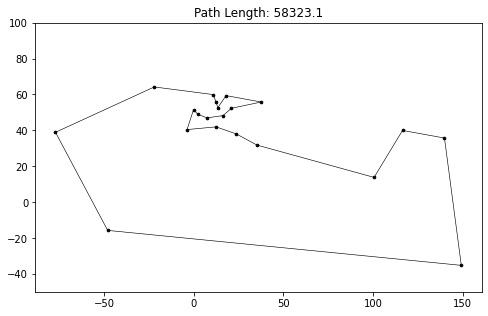

In [415]:
best_path = ants.run_ants()
ants.plot_path(best_path)
plt.ylim(-50,100)

In [416]:
in_order = np.arange(len(capitals_points))
print(f"path length for cities in order: {ants.path_length(in_order):,.0f} km")

path length for cities in order: 127,342 km


In [417]:
path_length = ants.path_length(best_path)
print(f"best path found: {path_length:,.0f} km")

best path found: 58,323 km


In [418]:
from shapely.geometry import Point, LineString

worldpath = LineString(gdf_capitals.iloc[best_path]['geometry'].values)

gdf_path = gpd.GeoDataFrame(geometry=[worldpath], crs='epsg:4326')

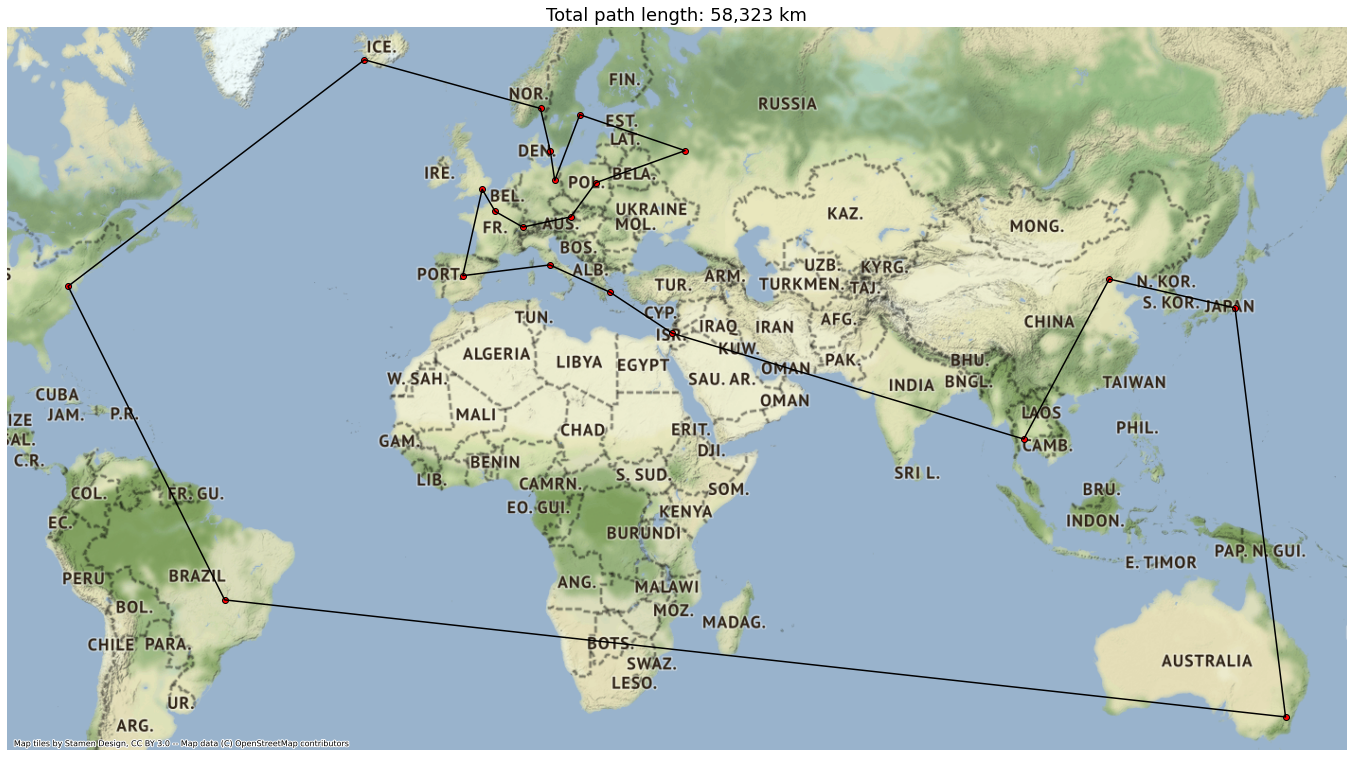

In [419]:
fig, ax = plt.subplots(figsize=(24,24))
gdf_capitals.to_crs('epsg:3857').plot(ax=ax, color='r', edgecolor='k')
gdf_path.to_crs('epsg:3857').plot(ax=ax, color='black')
ctx.add_basemap(ax)
ax.set_axis_off()
ax.set_title(f'Total path length: {path_length:,.0f} km', fontsize=18)
plt.savefig('images/capitals_path.png', bbox_inches='tight', transparent=True, dpi=150)